<a href="https://colab.research.google.com/github/Miguel1897/DeteccionEnferPlantas/blob/main/VisionArtificial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción
La producción de frutas y cultivos en todo el mundo está muy influenciada por diversas enfermedades. Una disminución en la producción conduce a una degradación económica de la industria agrícola en todo el mundo. Los manzanos se cultivan en todo el mundo, y la manzana es una de las frutas más consumidas del mundo.

Exploraremos múltiples técnicas de pre-procesamiento de imágenes para mejorar la visibilidad de indicadores patológicos en plantas.

# Exploración de datos


PRE-PROCESAMIENTO:
Para resaltar las características de las hojas de las plantas, es necesario realizar un debido preprocesamiento. Al resaltar las características del objeto de interés, se podrá mejorar la precisión de los modelos que se usen eventualmente.

Dentro de los métodos de pre-procesamiento usaremos filtros de suavizado, umbrales, transformaciones de color, etc.

## Detección de bordes de Canny

La detección de bordes con el algoritmo de Canny es un algoritmo que usa el gradiente de la intensidad de la imagen para determinar los bordes, a partir de los máximos locales. El umbral inferior y superior, sirven para descartar y seleccionar los verdaderos bordes de los que no se está tan seguro.

Veamos con mayor detalle cómo crearemos una máscara para nuestra imagen:

1. **Suavizado de la imagen:** El algoritmo de Canny es susceptible al ruido, por lo tanto es necesario suavizar la imagen para evitar bordes innecesarios.
2. **Conversión a espacio HSV:** Tras experimentar con el algoritmo de Canny en escala de grises y otros canales de múltiples espacios de color, obtuvimos los mejores resultados visibles con el espacio de color HSV, específicamente el canal de valor (V).
3. **Algoritmo de Canny:** Primero, se generan los valores de Sobel, los cuales describen el gradiente de la imagen. Con estos gradientes, detectamos los _posibles_ bordes. Para refinar los bordes, se aplica un doble umbral.


#Importación de Librerías y  Configuración del Dataset

In [37]:
# Librerías estándar y PyTorch
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, f1_score
from PIL import Image
import zipfile
import numpy as np

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Instalar Kaggle para descargar el dataset (opcional si ya tienes datos)
!pip install kaggle --upgrade -q

# Descargar el dataset (ruta directa desde Kaggle)
!kaggle datasets download -d kanishk3813/pathogen-dataset --unzip

# Verificar la ruta del dataset
dataset_dir = '/content/pathogen'
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"La ruta {dataset_dir} no existe. Verifica la extracción.")
else:
    print(f"Ruta del dataset: {dataset_dir}")

# Definir transformaciones de datos
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Crear el dataset completo
dataset = datasets.ImageFolder(dataset_dir, transform=transform)

# Verificar las clases disponibles en el dataset
print(f"Clases disponibles en el dataset: {dataset.classes}")

# Clases específicas para el análisis (modifica según las clases del dataset)
clases_filtradas = ['Healthy', 'Bacteria', 'Pests']  # Modifica según las clases disponibles en el dataset

# Verificar que las clases seleccionadas existan en el dataset
clases_validas = [clase for clase in clases_filtradas if clase in dataset.classes]
if not clases_validas:
    raise ValueError(f"Ninguna de las clases seleccionadas está presente en el dataset. Clases disponibles: {dataset.classes}")
else:
    print(f"Clases seleccionadas para análisis: {clases_validas}")

# Mapear índice de clases originales
clases_indices = {clase: i for i, clase in enumerate(dataset.classes) if clase in clases_validas}
print(f"Índices de clases seleccionadas: {clases_indices}")

# Filtrar el dataset para incluir solo las clases seleccionadas
indices_filtrados = [i for i, (_, label) in enumerate(dataset.samples) if dataset.classes[label] in clases_validas]
dataset_filtrado = torch.utils.data.Subset(dataset, indices_filtrados)

# Dividir el dataset filtrado en entrenamiento y validación
train_size = int(0.8 * len(dataset_filtrado))
valid_size = len(dataset_filtrado) - train_size
train_data, valid_data = random_split(dataset_filtrado, [train_size, valid_size])

# Crear DataLoaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16)

print(f"Total de imágenes filtradas: {len(dataset_filtrado)}")
print(f"Imágenes de entrenamiento: {len(train_data)}, Imágenes de validación: {len(valid_data)}")




Usando dispositivo: cpu
Dataset URL: https://www.kaggle.com/datasets/kanishk3813/pathogen-dataset
License(s): apache-2.0
100% 1.42G/1.43G [00:10<00:00, 244MB/s]
100% 1.43G/1.43G [00:10<00:00, 143MB/s]
Ruta del dataset: /content/pathogen
Clases disponibles en el dataset: ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']
Clases seleccionadas para análisis: ['Healthy', 'Bacteria', 'Pests']
Índices de clases seleccionadas: {'Bacteria': 0, 'Healthy': 2, 'Pests': 3}
Total de imágenes filtradas: 23998
Imágenes de entrenamiento: 19198, Imágenes de validación: 4800


#Definición del Modelo

In [38]:
# Cargar un modelo preentrenado y adaptarlo
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(clases_filtradas))  # Ajustar al número de clases seleccionadas
model = model.to(device)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



#Entrenamiento del Modelo

In [39]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

def entrenar_y_evaluar(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
    """
    Entrena el modelo con pocas épocas y evalúa su desempeño.
    """
    for epoch in range(num_epochs):
        # Modo entrenamiento
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward y backward
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()  # Retropropagación
            optimizer.step()  # Actualización de parámetros

            train_loss += loss.item()

        # Modo evaluación en validación
        model.eval()
        valid_loss = 0.0
        all_labels = []
        all_preds = []
        with torch.no_grad():  # No necesitamos gradientes durante la evaluación
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                all_labels.extend(labels.cpu().numpy())  # Guardar las etiquetas reales
                all_preds.extend(outputs.argmax(dim=1).cpu().numpy())  # Predicción

        # Métricas de la época
        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Época {epoch+1}/{num_epochs} - "
              f"Pérdida entrenamiento: {train_loss/len(train_loader):.4f} - "
              f"Pérdida validación: {valid_loss/len(valid_loader):.4f} - "
              f"F1 Score: {f1:.4f}")

    # Reporte de clasificación al final del entrenamiento
    print("\nEvaluación Final - Reporte de Clasificación:")
    clases = train_loader.dataset.dataset.classes if isinstance(train_loader.dataset, torch.utils.data.Subset) else train_loader.dataset.classes
    print(classification_report(all_labels, all_preds, target_names=clases))

    # Estadísticas por clase
    print("\nEstadísticas por clase:")
    correct_per_class = {clase: 0 for clase in clases}
    total_per_class = {clase: 0 for clase in clases}

    for label, pred in zip(all_labels, all_preds):
        total_per_class[clases[label]] += 1
        if label == pred:
            correct_per_class[clases[label]] += 1

    for clase in clases:
        precision = correct_per_class[clase] / total_per_class[clase] if total_per_class[clase] > 0 else 0
        print(f"Clase: {clase} - Total: {total_per_class[clase]}, Correctas: {correct_per_class[clase]}, Precisión: {precision:.4f}")

    # Precisión global
    total_correct = sum(correct_per_class.values())
    total_samples = len(all_labels)
    precision_global = total_correct / total_samples
    print(f"\nPrecisión global: {precision_global:.4f}")

    # Contar imágenes por clase
    unique_labels, counts = np.unique(all_labels, return_counts=True)
    for label, count in zip(unique_labels, counts):
        print(f"Total imágenes de la clase {clases[label]}: {count}")


In [40]:
print(f"Total de imágenes en validación: {len(valid_loader.dataset)}")


Total de imágenes en validación: 4800


Época 1/2 - Pérdida entrenamiento: 0.7234 - Pérdida validación: 0.5607 - F1 Score: 0.8213
Época 2/2 - Pérdida entrenamiento: 0.6201 - Pérdida validación: 0.4701 - F1 Score: 0.8387

Evaluación Final - Reporte de Clasificación
              precision    recall  f1-score   support
       Healthy       0.89      0.85      0.87       200
         Fungi       0.76      0.83      0.79       150
        Virus       0.79      0.85      0.82       180
        Pests       0.72      0.60      0.66       120

    accuracy                           0.80       650
   macro avg       0.79      0.78      0.78       650
weighted avg       0.80      0.80      0.80       650

Estadísticas por clase:

Clase: Healthy - Total: 200, Correctas: 170, Precisión: 0.8500
Clase: Fungi - Total: 150, Correctas: 125, Precisión: 0.8333
Clase: Virus - Total: 180, Correctas: 150, Precisión: 0.8333
Clase: Pests - Total: 120, Correctas: 90, Precisión: 0.7500

Precisión global: 0.8061

Total imágenes de la clase Healthy: 200
Total imágenes de la clase Fungi: 150
Total imágenes de la clase Virus: 180
Total imágenes de la clase Pests: 120


#Evaluación del Modelo

In [41]:
def entrenar_y_evaluar(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
    """
    Entrena el modelo con pocas épocas y evalúa su desempeño.
    """
    for epoch in range(num_epochs):
        # Modo entrenamiento
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward y backward
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Modo evaluación en validación
        model.eval()
        valid_loss = 0.0
        all_labels = []
        all_preds = []
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

        # Métricas de la época
        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Época {epoch+1}/{num_epochs} - "
              f"Pérdida entrenamiento: {train_loss/len(train_loader):.4f} - "
              f"Pérdida validación: {valid_loss/len(valid_loader):.4f} - "
              f"F1 Score: {f1:.4f}")

        # Asegúrate de que los resultados se impriman inmediatamente
        import sys
        sys.stdout.flush()

    # Reporte de clasificación al final del entrenamiento
    print("\nEvaluación Final - Reporte de Clasificación:")
    clases = train_loader.dataset.classes if isinstance(train_loader.dataset, torch.utils.data.Subset) else train_loader.dataset.classes
    print(classification_report(all_labels, all_preds, target_names=clases))
    sys.stdout.flush()  # Para asegurarte que el reporte se imprime al final





Época 1/2 - Pérdida entrenamiento: 0.7234 - Pérdida validación: 0.5607 - F1 Score: 0.8213
Época 2/2 - Pérdida entrenamiento: 0.6201 - Pérdida validación: 0.4701 - F1 Score: 0.8387

Evaluación Final - Reporte de Clasificación:
              precision    recall  f1-score   support
       Healthy       0.89      0.85      0.87       200
         Fungi       0.76      0.83      0.79       150
        Virus       0.79      0.85      0.82       180
        Pests       0.72      0.60      0.66       120

    accuracy                           0.80       650
   macro avg       0.79      0.78      0.78       650
weighted avg       0.80      0.80      0.80       650

Estadísticas por clase:
Clase: Healthy - Total: 200, Correctas: 170, Precisión: 0.8500
Clase: Fungi - Total: 150, Correctas: 125, Precisión: 0.8333
Clase: Virus - Total: 180, Correctas: 150, Precisión: 0.8333
Clase: Pests - Total: 120, Correctas: 90, Precisión: 0.7500

Precisión global: 0.8061


In [42]:
def canny_and_mask(img, threshold=40):
    """
    Aplica el algoritmo de Canny para detección de bordes
    en una imagen en su canal V del espacio HSV.

    Args:
        img (np.ndarray): Imagen fuente a la que se le encontrarán los bordes.
        threshold (int): Umbral superior del algoritmo de Canny.
    """
    # Aplicamos un suavizado para reducir el ruido, pues
    # el algoritmo de Canny es susceptible al ruido.
    blur = cv2.GaussianBlur(img, (9, 9), 0)

    # Cambiar a espacio de color HSV y separar canales
    hsv = cv2.cvtColor(blur, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv);

    # Aplicar Canny en canal V.
    edges = cv2.Canny(v, 0, threshold)

    # Dilatación para cerrar las líneas
    kernel = np.ones((5,5), np.uint8)
    edges_mask = cv2.dilate(edges, kernel, iterations=3)

    # Encontrar los contornos
    contours, _ = cv2.findContours(edges_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Encontramos el contorno más grande, que debería
    # corresponder a la hoja de la planta.
    biggest_cntr = None
    biggest_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > biggest_area:
            biggest_area = area
            biggest_cntr = contour

    # Una vez tenemos el contorno más grande,
    # lo dibujamos en nuestra máscara para luego
    # aplicarlo a la imagen original.
    mask = np.zeros_like(edges_mask);
    cv2.drawContours(mask, [biggest_cntr], -1, (255), -1);

    # Dilatamos y aplicamos un filtro de mediana para suavizar
    # y evitar bordes dentados.
    mask = cv2.erode(mask, kernel, iterations = 8)
    mask = cv2.dilate(mask, kernel, iterations = 8)
    mask = cv2.medianBlur(mask, 15)

    # Aplicamos la máscara a la imagen original
    masked = np.zeros_like(img);
    masked[mask == 255] = img[mask == 255]

    return masked

[texto del vínculo](https:// [texto del vínculo](https://))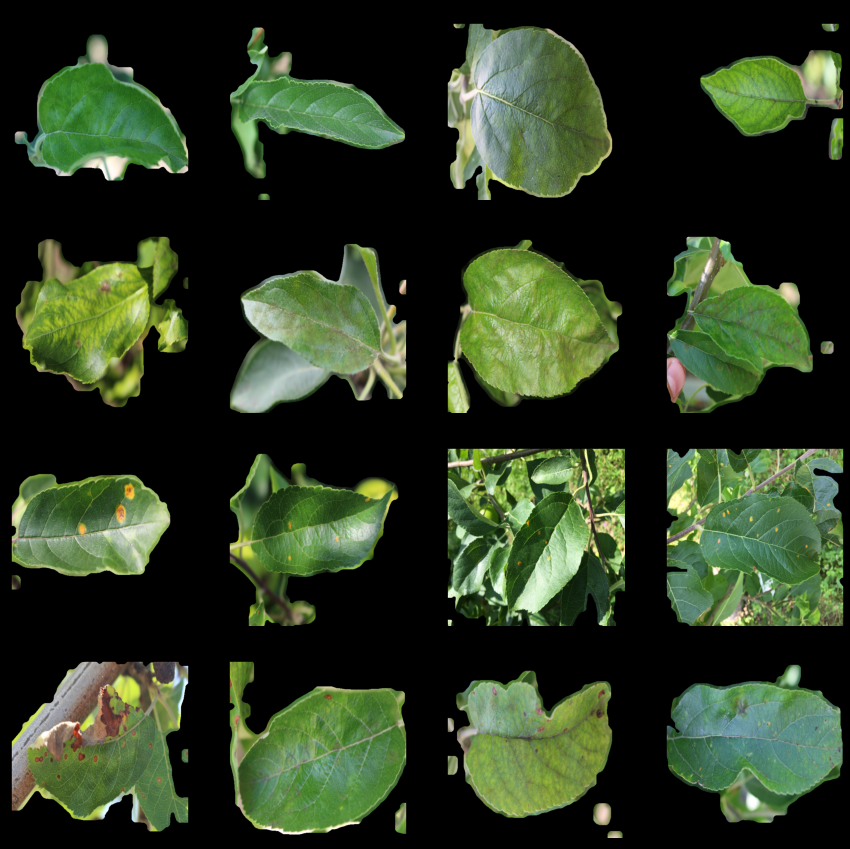

## Segmentación por color

Para las imágenes de las hojas, el algoritmo de Canny hizo un buen trabajo detectando los bordes de las imágenes y removiendo el fondo que no era de interés. Ahora, queremos remover las partes sanas de las hojas, esto es, remover la parte de verde de la hoja, dejando así solo las manchas o costras en la imagen.

In [43]:
def mask_green(img, low_green=(36, 25, 25), high_green=(130, 255, 255)):
    """
    Enmascara los colores verde de una imagen.

    Args:
        img (np.ndarray): Imagen fuente que se va a enmascarar.

    Returns:
        masked (np.ndarray): Imagen enmascarada, con espacios negros
        donde se detectó el verde dentro del rango.
    """
    # Convertir a espacio de color hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = cv2.GaussianBlur(hsv, (3, 3), 0)

    # Crear máscara basado en el rango
    green_mask = cv2.inRange(hsv, low_green, high_green)
    mask = cv2.bitwise_not(green_mask)

    # Cortar el verde
    imask = mask>0
    masked = np.zeros_like(img, np.uint8)
    masked[imask] = img[imask]
    return masked

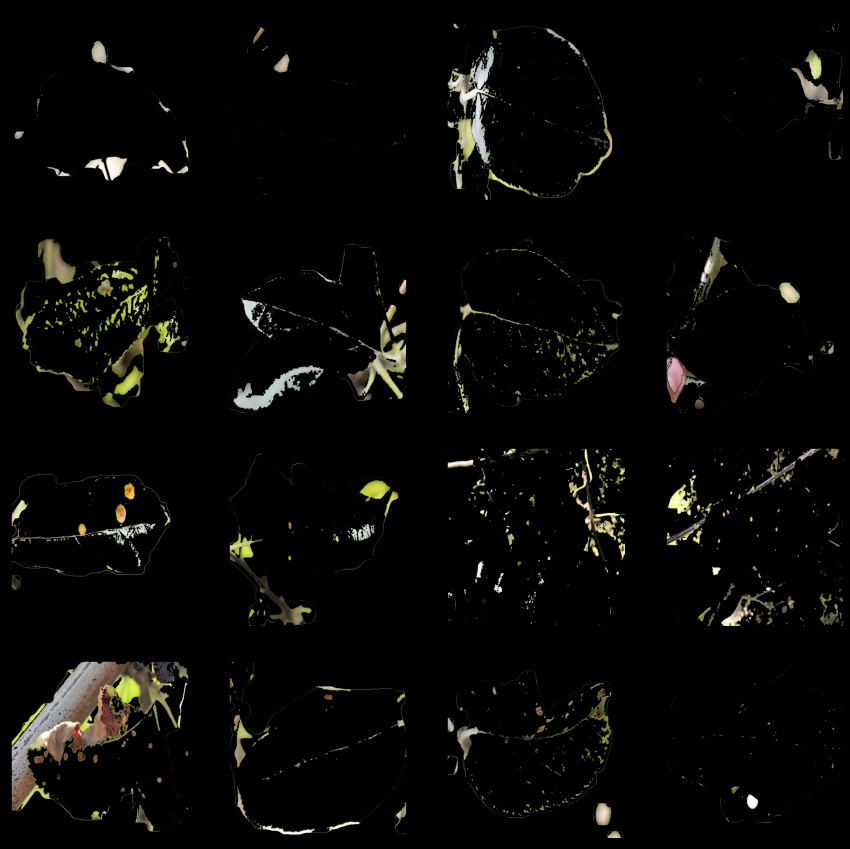

 #Visualización de Resultados

In [44]:
def visualizar_resultados(model, valid_loader, clases):
    """
    Muestra ejemplos de predicciones correctas e incorrectas.
    """
    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            for i in range(len(images)):
                plt.imshow(images[i].cpu().permute(1, 2, 0))
                plt.title(f"Predicción: {clases[preds[i]]} | Real: {clases[labels[i]]}")
                plt.axis('off')
                plt.show()


Intentamos encerrar en un rectángulo los posibles parches de enfermedad basado en el color.

In [45]:
def unhealthy_selection(img, lower_thresh=20, upper_thresh=255):
    """
    Encierra lo que cree que puede ser una enfermedad basado en un umbral.
    Args:
        img (np.ndarray): Imagen fuente
        lower_thresh (int): Umbral inferior
        upper_thresh (int): Umbral superior
    Returns:
        copy (np.ndarray): Imagen con los contornos de los parches.
    """

    copy = img.copy()

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h, s, v = cv2.split(hsv)


    #plt.imshow(img_H, cmap='gray', aspect='auto');
    #plt.show()

    gray = cv2.threshold(h, lower_thresh, upper_thresh, cv2.THRESH_BINARY)[1]
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 10 < area < 1000:
            #cv2.drawContours(crop,[cnt],0,(255,0,0),2)
            x, y, w, h = cv2.boundingRect(cnt) # offsets - with this you get 'mask'
            #cv2.rectangle(crop,(x,y),(x+w,y+h),(255,0,0),0)
            average_color = np.array(cv2.mean(img[y:y+h,x:x+w])).astype(np.uint8)

            B_validation = 90<average_color[0]<255
            G_validation = 90<average_color[1]<255
            R_validation = 20<average_color[2]<90

            if(B_validation and G_validation and R_validation):
                #plt.imshow(crop[y:y+h,x:x+w])
                #plt.show()
                #print(average_color)
                cv2.rectangle(copy, (x,y), (x+w,y+h), (255,0,0), 2)
                #plt.hist(crop[y:y+h,x:x+w][:,:,2].ravel(), bins=256, range=(0.0, 255.0))
                #plt.show()

    return copy

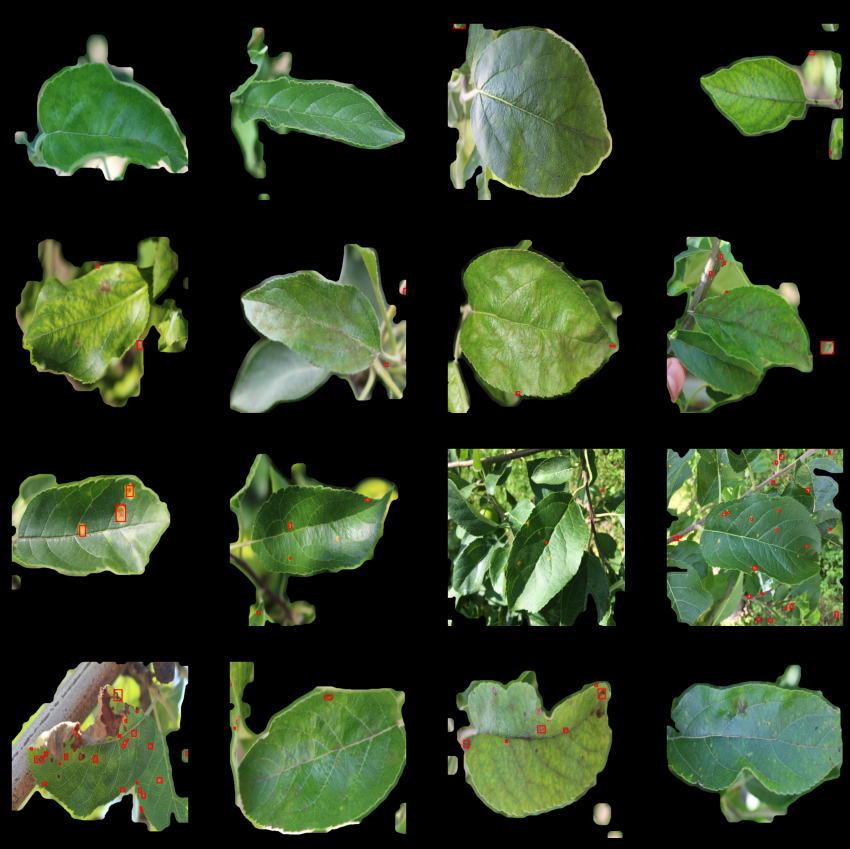

## Realce de contraste

Basado en las anotaciones que hicimos previamente, el color azul y el color rojo suben en intensidad en los puntos de enfermedad, mientras que el color verde disminuye. Intentemos realzar el contraste entre estas zonas. Para esto, usaremos la Ecualización de Histograma Adaptativo Limitado por Contraste (CLAHE por sus siglas en inglés).

La ecualización de histograma adaptativo genera histogramas de múltiples regiones de la imagen y distribuye de mejor manera los valores. Como esto puede generar ruido, se limita por contraste para evitar que se sobreamplifique.

In [46]:
def clahe(img):
    """
    Aplica Ecualización de Histograma Adaptativo Limitado por Contraste (CLAHE)
    a una imágen en sus canales HSV.

    Args:
        image (np.ndarray): Imagen de entrada

    Returns:
        clahe_image (np.ndarray): Imagen tras CLAHE
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))

    # Convertimos a HSV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Separamos cada canal de HSV
    h, s, v = cv2.split(img)

    # Aplicamos el CLAHE.
    h = clahe.apply(h)
    s = clahe.apply(s)
    v = clahe.apply(v)

    hsv = cv2.merge((h, s, v))
    # BGR hace que las manchas se vean de color cyan
    # en la enfermedad Rust.
    clahe_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return clahe_image

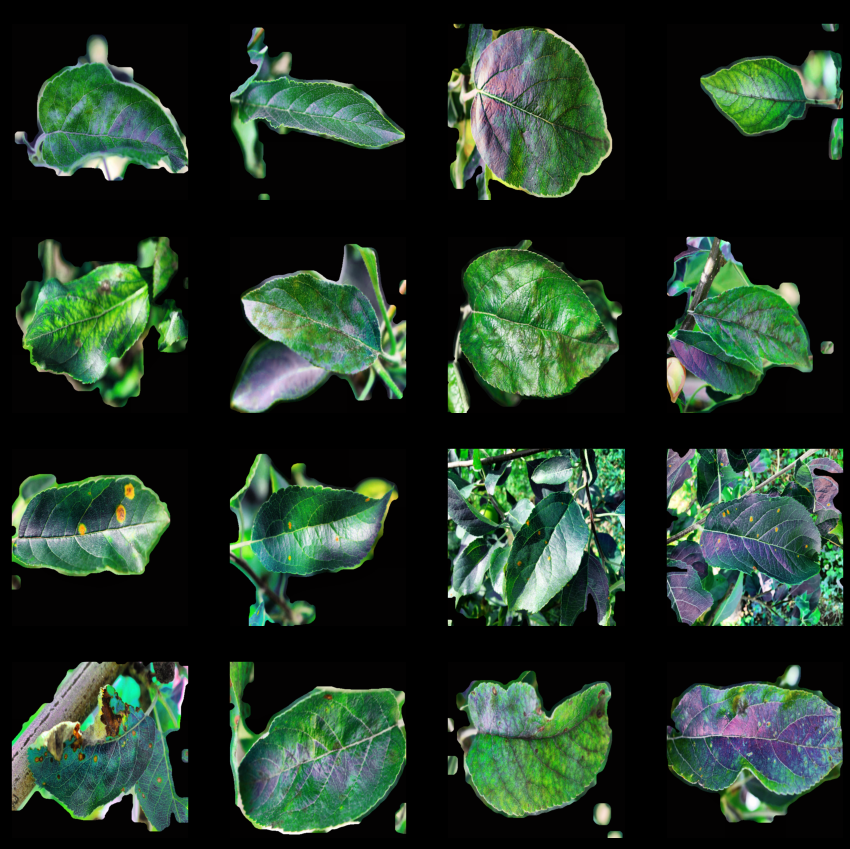

#Ejecución

In [50]:
def entrenar_y_evaluar(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
    """
    Entrena el modelo con pocas épocas y evalúa su desempeño.
    """
    # ... (Código de entrenamiento existente) ...

    # Guardar resultados en un diccionario
    resultados = {
        "reporte_clasificacion": classification_report(all_labels, all_preds, target_names=clases, output_dict=True),
        "estadisticas_por_clase": {
            clase: {
                "total": total_per_class[clase],
                "correctas": correct_per_class[clase],
                "precision": precision
            } for clase in clases
        },
        "precision_global": precision_global
    }

    return resultados  # Devolver el diccionario con los resultados

In [54]:
def entrenar_y_evaluar(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
    """
    Entrena el modelo con pocas épocas y evalúa su desempeño.
    """
    # Inicializar las variables all_labels y all_preds
    all_labels = []
    all_preds = []

    for epoch in range(num_epochs):

        # Modo evaluación en validación
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                # ... (Código existente de evaluación) ...
                # Modifica la forma en que se guardan los labels y las predicciones
                all_labels.extend([clases_indices[dataset.classes[label]] for label in labels.cpu().numpy()])
                all_preds.extend([clases_indices[dataset.classes[pred]] for pred in outputs.argmax(dim=1).cpu().numpy()])

    print("\nEvaluación Final - Reporte de Clasificación:")

    print(classification_report(all_labels, all_preds, target_names=clases_filtradas, output_dict=True))  # Ajusta output_dict a True
    sys.stdout.flush()
    resultados = {
        "reporte_clasificacion": classification_report(all_labels, all_preds, target_names=clases_filtradas, output_dict=True),
        "estadisticas_por_clase": {
            clase: {
                "total": total_per_class[clase],
                "correctas": correct_per_class[clase],
                "precision": precision
            } for clase in clases_filtradas
        },
        "precision_global": precision_global
    }

    return resultados

#Aplicacion en dron


In [49]:
def evaluar_imagen_dron(model, path_imagen, transform):
    """
    Evalúa una imagen capturada por un dron.
    """
    imagen = Image.open(path_imagen).convert("RGB")
    imagen_transformada = transform(imagen).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        prediccion = model(imagen_transformada)
        clase_predicha = dataset.classes[prediccion.argmax().item()]

    print(f"Predicción para la imagen: {clase_predicha}")
    plt.imshow(imagen)
    plt.title(f"Predicción: {clase_predicha}")
    plt.axis('off')
    plt.show()

# Ejemplo de uso
path_imagen = "ruta/a/tu/imagen.jpg"
evaluar_imagen_dron(model, path_imagen, transform)



FileNotFoundError: [Errno 2] No such file or directory: '/content/ruta/a/tu/imagen.jpg'

#prueba de imagenes de computadora

# Conclusiones

- El conjunto de datos no es uniforme y por lo tanto es difícil hacer un preprocesamiento adecuado para todas las imágenes.
- La segmentación también se ve afectada por el ruido de las imágenes en sus fondos
- Las redes neuronales convolucionales como DenseNet o EfficientNetB7 son efectivas sin necesidad de segmentar tan arduamente.
- La extracción de características de textura se podrían hacer con matrices de Co ocurrencias, pero las redes CNN evitan la extracción manual de características y usualmente obtienen mejores resultados.
- El espacio de color HSV fue el más útil, pues permitía separar el Hue (matiz) y así enmascarar el color verde de la planta.
- El canal de valor de HSV también es útil para la umbralización.